In [1]:
import os
import cv2
import warnings
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')
DAT_PATH = 'dataset/'
TARGET = 'MAP'
random_seed = 42
IMG_WIDTH = 256
IMG_HEIGHT = 256
n_split= 0.75

In [15]:
IMPATH = DAT_PATH+'ISIC2018_Task1-2_Training_Input/'
SEGPATH = DAT_PATH+'ISIC2018_Task1_Training_GroundTruth/' 
ATRPATH = DAT_PATH+'ISIC2018_Task2_Training_GroundTruth_v3/'



INPATH = DAT_PATH+'IMAGES/'
OUPATH = DAT_PATH+TARGET+'/'

filenames = ['ISIC_0000111.jpg','ISIC_0014867.jpg','ISIC_0015625.jpg','ISIC_0010332.jpg','ISIC_0000013.jpg']


In [16]:
def create_folder(path,name):
    import os
    try:
        path=path+name
        os.mkdir(path)
    except OSError:
        print ("Exist or Failed the directory %s" % path)
    else:
        print ("Successfully created the directory %s " % path)

In [17]:
create_folder(OUPATH,'')
create_folder(INPATH,'')
create_folder('images','')
create_folder('results','')
create_folder('results/','output_'+TARGET)
create_folder('results/','checkpoints_'+TARGET)

Exist or Failed the directory dataset/MAP/
Exist or Failed the directory dataset/IMAGES/
Exist or Failed the directory images
Exist or Failed the directory results
Exist or Failed the directory results/output_MAP
Exist or Failed the directory results/checkpoints_MAP


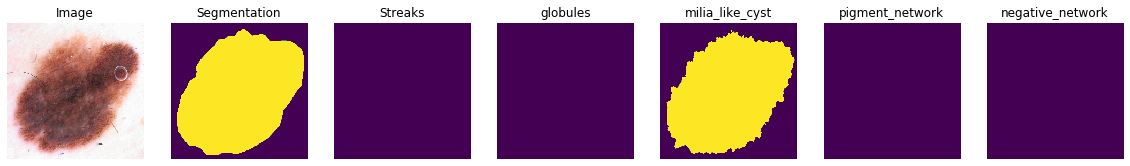

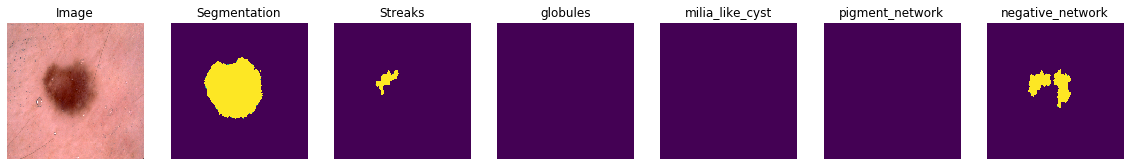

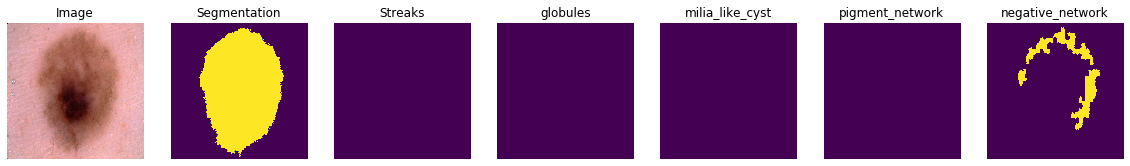

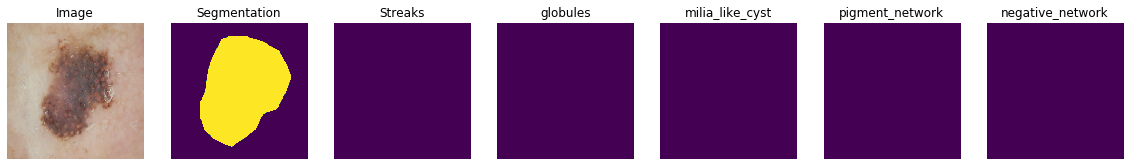

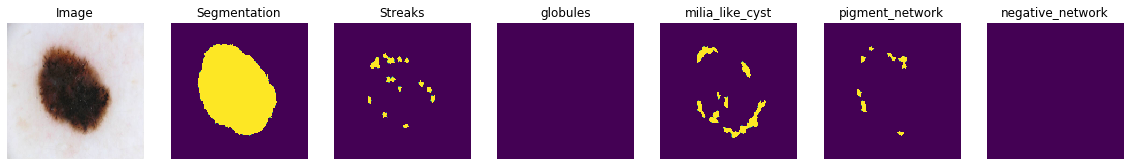

In [19]:
for filename in filenames:
    
    img = cv2. imread(IMPATH+filename)
    seg = cv2. imread(SEGPATH+filename[:12]+'_segmentation.png')
    streak = cv2.imread(ATRPATH+filename[:12]+'_attribute_streaks.png')
    globules = cv2.imread(ATRPATH+filename[:12]+'_attribute_globules.png')
    milia =  cv2.imread(ATRPATH+filename[:12]+'_attribute_milia_like_cyst.png')
    pigment = cv2.imread(ATRPATH+filename[:12]+'_attribute_pigment_network.png')
    negative = cv2.imread(ATRPATH+filename[:12]+'_attribute_negative_network.png')

    
    if(TARGET == 'MAP'):
        map_image = np.zeros((img.shape[0],img.shape[1],6), dtype=np.uint8)
        idx=0
        map_image[seg[:,:,idx]>0,0]=255 
        map_image[globules[:,:,idx]>0,1] = 255
        map_image[milia[:,:,idx]>0,2] = 255    
        map_image[pigment[:,:,idx]>0,3] = 255 
        map_image[streak[:,:,idx]> 0,4] = 255
        map_image[negative[:,:,idx]>0,5] = 255
        
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        map_image1 = cv2.resize(map_image[:,:,0:3], (IMG_HEIGHT, IMG_WIDTH))#, interpolation = cv2.INTER_AREA )
        map_image2 = cv2.resize(map_image[:,:,3:], (IMG_HEIGHT, IMG_WIDTH) )#,interpolation = cv2.INTER_AREA )
        map_image =np.concatenate((map_image1, map_image2), axis=2)
        map_image = np.array(map_image,dtype=np.uint8)
                
        cv2.imwrite('images/'+TARGET+'_'+filename[:12]+'_1.png',cv2.cvtColor(map_image[:,:,0:3], cv2.COLOR_BGR2RGB))
        cv2.imwrite('images/'+TARGET+'_'+filename[:12]+'_2.png',cv2.cvtColor(map_image[:,:,3:], cv2.COLOR_BGR2RGB))

        map_image1 = plt.imread('images/'+TARGET+'_'+filename[:12]+'_1.png')
        map_image2 = plt.imread('images/'+TARGET+'_'+filename[:12]+'_2.png')
        map_image =np.concatenate((map_image1, map_image2), axis=2)
        
    else:
        
        map_image = np.zeros((img.shape[0],img.shape[1],1), dtype=np.uint8)
        
        map_image[seg[:,:,1]>0,:]=255 
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        map_image = cv2.resize(map_image, (IMG_HEIGHT, IMG_WIDTH))

    if(TARGET == 'MAP'):
        fig, axs = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Image')
        axs[0].axis('off')
        axs[1].imshow(map_image[:,:,0])
        axs[1].set_title('Segmentation')
        axs[1].axis('off')
        axs[2].imshow(map_image[:,:,1])
        axs[2].set_title('Streaks')
        axs[2].axis('off')
        axs[3].imshow(map_image[:,:,2])
        axs[3].set_title('globules')
        axs[3].axis('off')
        axs[4].imshow(map_image[:,:,3])
        axs[4].set_title('milia_like_cyst')
        axs[4].axis('off')
        axs[5].imshow(map_image[:,:,4])
        axs[5].set_title('pigment_network')
        axs[5].axis('off')
        axs[6].imshow(map_image[:,:,5])
        axs[6].set_title('negative_network')
        axs[6].axis('off')
        #fig.suptitle('Categorical Plotting')
        plt.savefig('images/'+TARGET+'_'+filename)
        
    else:
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
        axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Image')
        axs[1].imshow(map_image)
        axs[1].set_title('Segmentation')
        #fig.suptitle('Categorical Plotting')
        plt.savefig('images/'+TARGET+'_'+filename)
    


In [6]:
map_image[:,:,0:3].shape

(256, 256, 3)

In [9]:
def create_map(filename):
    # LECTURA DE IMAGEN
    img = cv2. imread(IMPATH+filename)
    if (img is None) or (len(img)==0):
        return 
    # LECTURA DE MELANOMA SEGMENT
    seg = cv2. imread(SEGPATH+filename[:12]+'_segmentation.png')
    if (seg is None) or (len(seg)==0):
        return 
    
    # LECTURA DE MASCARAS
    streak = cv2.imread(ATRPATH+filename[:12]+'_attribute_streaks.png')
    globules = cv2.imread(ATRPATH+filename[:12]+'_attribute_globules.png')
    milia =  cv2.imread(ATRPATH+filename[:12]+'_attribute_milia_like_cyst.png')
    pigment = cv2.imread(ATRPATH+filename[:12]+'_attribute_pigment_network.png')
    negative = cv2.imread(ATRPATH+filename[:12]+'_attribute_negative_network.png')
    
    
    if(TARGET == 'MAP'):
        map_image = np.zeros((img.shape[0],img.shape[1],6), dtype=np.uint8)
        
        map_image[seg[:,:,1]>0,0]=255 
        map_image[globules[:,:,1]>0,1] = 255
        map_image[milia[:,:,1]>0,2] = 255    
        map_image[pigment[:,:,1]>0,3] = 255 
        map_image[streak[:,:,1]> 0,4] = 255
        map_image[negative[:,:,1]>0,5] = 255
        
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        map_image1 = cv2.resize(map_image[:,:,0:3], (IMG_HEIGHT, IMG_WIDTH))
        map_image2 = cv2.resize(map_image[:,:,3:], (IMG_HEIGHT, IMG_WIDTH))
        map_image =np.concatenate((map_image1, map_image2), axis=2)
        map_image = np.array(map_image,dtype=np.uint8)
                
        cv2.imwrite(OUPATH+filename[:12]+'_1.png',cv2.cvtColor(map_image[:,:,0:3], cv2.COLOR_BGR2RGB))
        cv2.imwrite(OUPATH+filename[:12]+'_2.png',cv2.cvtColor(map_image[:,:,3:], cv2.COLOR_BGR2RGB))

        cv2.imwrite(INPATH+filename,img)

    else:
        
        map_image = np.zeros((img.shape[0],img.shape[1],1), dtype=np.uint8)
        
        map_image[seg[:,:,1]>0,:]=255 
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        map_image = cv2.resize(map_image, (IMG_HEIGHT, IMG_WIDTH))
        cv2.imwrite(OUPATH+filename,cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
        cv2.imwrite(INPATH+filename,img)

    
    return [img,map_image]

In [10]:
imgurls = os.listdir(IMPATH)
results = Parallel(n_jobs=16)(delayed(create_map)(filename) for filename in tqdm(imgurls))
del results
print('Total images '+':', len(imgurls))
print('Total map    '+':', len(imgurls))

100%|██████████| 2596/2596 [04:50<00:00,  7.68it/s]


Total images : 2596
Total map    : 2596
